In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import warnings
import skimage
from skimage import io
import matplotlib
from skimage.io import imread
from skimage.color import rgb2grey
from skimage.feature import hog
from skimage.transform import resize
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics.pairwise import chi2_kernel

In [2]:
def get_image_paths(data_path, categories, num_train_per_cat):
    '''
    This function returns lists containing the file path for each train
    and test image, as well as lists with the label of each train and
    test image. By default both lists will be 1500x1, where each
    entry is a char array (or string).
    '''

    num_categories = len(categories) # number of scene categories.

    # This paths for each training and test image. By default it will have 1500
    # entries (15 categories * 100 training and test examples each)
    train_image_paths = [None] * (num_categories * num_train_per_cat)
    test_image_paths  = [None] * (num_categories * num_train_per_cat)

    # The name of the category for each training and test image. With the
    # default setup, these arrays will actually be the same, but they are built
    # independently for clarity and ease of modification.
    train_labels = [None] * (num_categories * num_train_per_cat)
    test_labels  = [None] * (num_categories * num_train_per_cat)

    for i,cat in enumerate(categories):
        images = glob.glob(os.path.join(data_path, 'train', cat, '*.jpg'))

        for j in range(num_train_per_cat):
            train_image_paths[i * num_train_per_cat + j] = images[j]
            train_labels[i * num_train_per_cat + j] = cat

        images = glob.glob(os.path.join(data_path, 'test', cat, '*.jpg'))
        for j in range(num_train_per_cat):
            test_image_paths[i * num_train_per_cat + j] = images[j]
            test_labels[i * num_train_per_cat + j] = cat

    return (train_image_paths, test_image_paths, train_labels, test_labels) 


In [3]:
# Skimage gives us some lossy conversion errors that we really don't care about
# so we suppress them
warnings.filterwarnings('ignore', '', UserWarning)

def create_results_webpage(train_image_paths, test_image_paths,
	train_labels, test_labels,
	categories, abbr_categories, predicted_categories):

	'''
	Starter code prepared by James Hays for CSCI 1430 Computer Vision
	Converted to Python by Brendan Walsh
	This function creates a webpage (html and images) visualizing the
	classiffication results. This webpage will contain:
	 (1) A confusion matrix plot
	 (2) A table with one row per category, with 4 columns - training
		 examples, true positives, false positives, and false negatives.
	False positives are instances claimed as that category but belonging to
	another category, e.g. in the 'forest' row an image that was classified
	as 'forest' but is actually 'mountain'. This same image would be
	considered a false negative in the 'mountain' row, because it should have
	been claimed by the 'mountain' classifier but was not.
	This webpage is similar to the one created for the SUN database in
	2010: http://people.csail.mit.edu/jxiao/SUN/classification397.html
	'''

	print('Creating results_webpage/index.html, thumbnails, and confusion matrix.')

	# Number of examples of training examples, true positives, false positives,
	# and false negatives. Thus the table will be num_samples * 4 images wide
	# (unless there aren't enough images)
	num_samples = 2
	thumbnail_height = 75 #pixels
	num_categories = len(categories)

	# Convert everything over to numpy arrays
	categories = np.array(categories)
	predicted_categories = np.array(predicted_categories)
	train_labels = np.array(train_labels)
	test_labels = np.array(test_labels)

	# Delete the old thumbnails, if there are any
	files = glob.glob('results_webpage/thumbnails/*.jpg')
	for f in files:
		os.remove(f)

	if not os.path.isdir('results_webpage'):
		print('Making results_webpage directory.')
		os.mkdir('results_webpage')
	if not os.path.isdir('results_webpage/thumbnails'):
		print('Making thumbnails directory.')
		os.mkdir('results_webpage/thumbnails')

	### Create And Save Confusion Matrix ###
	# Based on the predicted category for each test case, we will now build a
	# confusion matrix. Entry (i,j) in this matrix well be the proportion of
	# times a test image of ground truth category i was predicted to be
	# category j. An identity matrix is the ideal case. You should expect
	# roughly 50-95% along the diagonal depending on your features,
	# classifiers, and particular categories. For example, suburb is very easy
	# to recognize.
	with open('results_webpage/index.html', 'w+') as f:

		# Initialize the matrix
		confusion_matrix = np.zeros((num_categories, num_categories))

		# Iterate over predicted results (this is like, several hundred items long)
		for i,cat in enumerate(predicted_categories):
			# Find the row and column corresponding to the label of this entry
			# The row is the ground truth label and the column is the found label
			row = np.argwhere(categories == test_labels[i])[0][0]
			column = np.argwhere(categories == predicted_categories[i])[0][0]

			# Add 1 to the matrix for that row/col
			# This way we build up a histogram from our labeled data
			confusion_matrix[row][column] += 1;

		# If the number of training examples and test cases are not equal, this
		# statement will be invalid!
		# TODO: That's an old comment left over from the matlab code that I don't
		# think still applies
		num_test_per_cat = len(test_labels) / num_categories
		confusion_matrix = confusion_matrix / float(num_test_per_cat)
		accuracy = np.mean(np.diag(confusion_matrix))

		print('Accuracy (mean of diagonal of confusion matrix) is {:2.3%}'.format(accuracy))

		# plasma is the most easily-interpreted color map I've found so far
		plt.imshow(confusion_matrix, cmap='plasma', interpolation='nearest')

		# We put the shortened labels (e.g. "sub" for "suburb") on the x axis
		locs, labels = plt.xticks()
		plt.xticks(np.arange(num_categories), abbr_categories)

		# Full labels go on y
		locs, labels = plt.yticks()
		plt.yticks(np.arange(num_categories), categories)

		# Save the result
		plt.savefig('results_webpage/confusion_matrix.png', bbox_inches='tight')

		## Create webpage header
		f.write('<!DOCTYPE html>\n');
		f.write('<html>\n');
		f.write('<head>\n');
		f.write('<link href=''http://fonts.googleapis.com/css?family=Nunito:300|Crimson+Text|Droid+Sans+Mono'' rel=''stylesheet'' type=''text/css''>\n');
		f.write('<style type="text/css">\n');

		f.write('body {\n');
		f.write('  margin: 0px;\n');
		f.write('  width: 100%;\n');
		f.write('  font-family: ''Crimson Text'', serif;\n');
		f.write('  background: #fcfcfc;\n');
		f.write('}\n');
		f.write('table td {\n');
		f.write('  text-align: center;\n');
		f.write('  vertical-align: middle;\n');
		f.write('}\n');
		f.write('h1 {\n');
		f.write('  font-family: ''Nunito'', sans-serif;\n');
		f.write('  font-weight: normal;\n');
		f.write('  font-size: 28px;\n');
		f.write('  margin: 25px 0px 0px 0px;\n');
		f.write('  text-transform: lowercase;\n');
		f.write('}\n');
		f.write('.container {\n');
		f.write('  margin: 0px auto 0px auto;\n');
		f.write('  width: 1160px;\n');
		f.write('}\n');

		f.write('</style>\n');
		f.write('</head>\n');
		f.write('<body>\n\n');

		f.write('<div class="container">\n\n\n');
		f.write('<center>\n');
		f.write('<h1>Scene classification results visualization</h1>\n');
		f.write('<img src="confusion_matrix.png">\n\n');
		f.write('<br>\n');
		f.write('Accuracy (mean of diagonal of confusion matrix) is %2.3f\n' % (accuracy));
		f.write('<p>\n\n');

		## Create results table
		f.write('<table border=0 cellpadding=4 cellspacing=1>\n');
		f.write('<tr>\n');
		f.write('<th>Category name</th>\n');
		f.write('<th>Accuracy</th>\n');
		f.write('<th colspan=%d>Sample training images</th>\n' % num_samples);
		f.write('<th colspan=%d>Sample true positives</th>\n' % num_samples);
		f.write('<th colspan=%d>False positives with true label</th>\n' % num_samples);
		f.write('<th colspan=%d>False negatives with wrong predicted label</th>\n' % num_samples);
		f.write('</tr>\n');

		for i,cat in enumerate(categories):
			f.write('<tr>\n');

			f.write('<td>'); #category name
			f.write('%s' % cat);
			f.write('</td>\n');

			f.write('<td>'); # category accuracy
			f.write('%.3f' % confusion_matrix[i][i]);
			f.write('</td>\n');

			# Collect num_samples random paths to images of each type.
			# Training examples.
			train_examples = np.take(train_image_paths, np.argwhere(train_labels == cat))

			# True positives. There might not be enough of these if the classifier
			# is bad
			true_positives = np.take(test_image_paths, np.argwhere(np.logical_and(test_labels == cat, predicted_categories == cat)))

			# False positives. There might not be enough of them if the classifier
			# is good
			false_positive_inds = np.argwhere(np.logical_and(np.invert(cat == test_labels), cat == predicted_categories))
			false_positives = np.take(test_image_paths, false_positive_inds)
			false_positive_labels = np.take(test_labels, false_positive_inds)

			# False negatives. There might not be enough of them if the classifier
			# is good
			false_negative_inds = np.argwhere(np.logical_and(cat == test_labels, np.invert(cat == predicted_categories)))
			false_negatives = np.take(test_image_paths, false_negative_inds)
			false_negative_labels = np.take(predicted_categories, false_negative_inds)

			# Randomize each list of files
			np.random.shuffle(train_examples)
			np.random.shuffle(true_positives)

			# HACK: Well, sort of a hack. We need to shuffle the false_positives
			# and their labels in the same exact order, so we get the RNG state,
			# save it, shuffle, restore, then shuffle the other list so that they
			# shuffle in tandem.
			rng_state = np.random.get_state()
			np.random.shuffle(false_positives)
			np.random.set_state(rng_state)
			np.random.shuffle(false_positive_labels)

			rng_state = np.random.get_state()
			np.random.shuffle(false_negatives)
			np.random.set_state(rng_state)
			np.random.shuffle(false_negative_labels)

			# Truncate each list to be at most num_samples long
			train_examples  = train_examples[0:min(len(train_examples), num_samples)]
			true_positives  = true_positives[0:min(len(true_positives), num_samples)]
			false_positives = false_positives[0:min(len(false_positives), num_samples)]
			false_positive_labels = false_positive_labels[0:min(len(false_positive_labels),num_samples)]
			false_negatives = false_negatives[0:min(len(false_negatives),num_samples)]
			false_negative_labels = false_negative_labels[0:min(len(false_negative_labels),num_samples)]

			# Sample training images
			# Create and save all of the thumbnails
			for j in range(num_samples):
				if j + 1 <= len(train_examples):
					thisExample = train_examples[j][0]
					tmp = skimage.io.imread(thisExample)
					height, width = rescale(tmp.shape, thumbnail_height)
					tmp = skimage.transform.resize(tmp, (height, width),
						anti_aliasing=True, mode='wrap')

					name = os.path.basename(thisExample)
					tmp_uint8 = (tmp * 255).astype(np.uint8)
					skimage.io.imsave('results_webpage/thumbnails/' + cat + '_' + name, tmp_uint8, quality=100)
					f.write('<td bgcolor=LightBlue>')
					f.write('<img src="%s" width=%d height=%d>' % ('thumbnails/' + cat + '_' + name, width, height))
					f.write('</td>\n')
				else:
					f.write('<td bgcolor=LightBlue>')
					f.write('</td>\n')

			for j in range(num_samples):
				if j + 1 <= len(true_positives):
					thisExample = true_positives[j][0]
					tmp = skimage.io.imread(thisExample)
					height, width = rescale(tmp.shape, thumbnail_height)
					tmp = skimage.transform.resize(tmp, (height, width),
						anti_aliasing=True, mode='wrap')

					name = os.path.basename(thisExample)
					tmp_uint8 = (tmp * 255).astype(np.uint8)
					skimage.io.imsave('results_webpage/thumbnails/' + cat + '_' + name, tmp_uint8, quality=100)
					f.write('<td bgcolor=LightGreen>');
					f.write('<img src="%s" width=%d height=%d>' % ('thumbnails/' + cat + '_' + name, width, height))
					f.write('</td>\n');
				else:
					f.write('<td bgcolor=LightGreen>');
					f.write('</td>\n');

			for j in range(num_samples):
				if j + 1 <= len(false_positives):
					thisExample = false_positives[j][0]
					tmp = skimage.io.imread(thisExample)
					height, width = rescale(tmp.shape, thumbnail_height)
					tmp = skimage.transform.resize(tmp, (height, width),
						anti_aliasing=True, mode='wrap')

					name = os.path.basename(thisExample)
					tmp_uint8 = (tmp * 255).astype(np.uint8)
					skimage.io.imsave('results_webpage/thumbnails/' + cat + '_' + name, tmp_uint8, quality=100)
					f.write('<td bgcolor=LightCoral>');
					f.write('<img src="%s" width=%d height=%d>' % ('thumbnails/' + cat + '_' + name, width, height))
					f.write('<br><small>%s</small>' % false_positive_labels[j][0]);
					f.write('</td>\n');
				else:
					f.write('<td bgcolor=LightCoral>');
					f.write('</td>\n');

			for j in range(num_samples):
				if j + 1 <= len(false_negatives):
					thisExample = false_negatives[j][0]
					tmp = skimage.io.imread(thisExample)
					height, width = rescale(tmp.shape, thumbnail_height)
					tmp = skimage.transform.resize(tmp, (height, width),
						anti_aliasing=True, mode='wrap')

					name = os.path.basename(thisExample)
					tmp_uint8 = (tmp * 255).astype(np.uint8)
					skimage.io.imsave('results_webpage/thumbnails/' + cat + '_' + name, tmp_uint8, quality=100)
					f.write('<td bgcolor=#FFBB55>');
					f.write('<img src="%s" width=%d height=%d>' % ('thumbnails/' + cat + '_' + name, width, height));
					f.write('<br><small>%s</small>' % false_negative_labels[j][0]);
					f.write('</td>\n');
				else:
					f.write('<td bgcolor=#FFBB55>');
					f.write('</td>\n');

			f.write('</tr>\n');

		f.write('<tr>\n');
		f.write('<th>Category name</th>\n');
		f.write('<th>Accuracy</th>\n');
		f.write('<th colspan=%d>Sample training images</th>\n' % num_samples);
		f.write('<th colspan=%d>Sample true positives</th>\n' % num_samples);
		f.write('<th colspan=%d>False positives with true label</th>\n' % num_samples);
		f.write('<th colspan=%d>False negatives with wrong predicted label</th>\n' % num_samples);
		f.write('</tr>\n');

		f.write('</table>\n');
		f.write('</center>\n\n\n');
		f.write('</div>\n');

		## Create end of web page
		f.write('</body>\n');
		f.write('</html>\n');

	print('Wrote results page to results_webpage/index.html.')

def rescale(dims, thumbnail_height):
	height = dims[1]
	factor = thumbnail_height / height
	left = int(round(dims[0] * factor))
	right = int(round(dims[1] * factor))
	return (left, right)

In [4]:
def get_tiny_images(image_paths):
    '''
    This feature is inspired by the simple tiny images used as features in
    80 million tiny images: a large dataset for non-parametric object and
    scene recognition. A. Torralba, R. Fergus, W. T. Freeman. IEEE
    Transactions on Pattern Analysis and Machine Intelligence, vol.30(11),
    pp. 1958-1970, 2008. http://groups.csail.mit.edu/vision/TinyImages/
    Inputs:
        image_paths: a 1-D Python list of strings. Each string is a complete
                     path to an image on the filesystem.
    Outputs:
        An n x d numpy array where n is the number of images and d is the
        length of the tiny image representation vector. e.g. if the images
        are resized to 16x16, then d is 16 * 16 = 256.
    To build a tiny image feature, resize the original image to a very small
    square resolution (e.g. 16x16). You can either resize the images to square
    while ignoring their aspect ratio, or you can crop the images into squares
    first and then resize evenly. Normalizing these tiny images will increase
    performance modestly.
    As you may recall from class, naively downsizing an image can cause
    aliasing artifacts that may throw off your comparisons. See the docs for
    skimage.transform.resize for details:
    http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
    Suggested functions: skimage.transform.resize, skimage.color.rgb2grey,
                         skimage.io.imread, np.reshape
    '''
    
    images = np.array([resize(imread(image_path), (16, 16)).reshape(-1) for image_path in image_paths])
#     print(images.shape)
    
    #TODO: Implement this function!
#     for image_path in image_paths:
#         image = resize(imread(image_path), (16, 16))
        
        
    return np.array(images)

In [5]:
def build_vocabulary(image_paths, vocab_size):
    '''
    This function should sample HOG descriptors from the training images,
    cluster them with kmeans, and then return the cluster centers.
    Inputs:
        image_paths: a Python list of image path strings
         vocab_size: an integer indicating the number of words desired for the
                     bag of words vocab set
    Outputs:
        a vocab_size x (z*z*9) (see below) array which contains the cluster
        centers that result from the K Means clustering.
    You'll need to generate HOG features using the skimage.feature.hog() function.
    The documentation is available here:
    http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog
    However, the documentation is a bit confusing, so we will highlight some
    important arguments to consider:
        cells_per_block: The hog function breaks the image into evenly-sized
            blocks, which are further broken down into cells, each made of
            pixels_per_cell pixels (see below). Setting this parameter tells the
            function how many cells to include in each block. This is a tuple of
            width and height. Your SIFT implementation, which had a total of
            16 cells, was equivalent to setting this argument to (4,4).
        pixels_per_cell: This controls the width and height of each cell
            (in pixels). Like cells_per_block, it is a tuple. In your SIFT
            implementation, each cell was 4 pixels by 4 pixels, so (4,4).
        feature_vector: This argument is a boolean which tells the function
            what shape it should use for the return array. When set to True,
            it returns one long array. We recommend setting it to True and
            reshaping the result rather than working with the default value,
            as it is very confusing.
    It is up to you to choose your cells per block and pixels per cell. Choose
    values that generate reasonably-sized feature vectors and produce good
    classification results. For each cell, HOG produces a histogram (feature
    vector) of length 9. We want one feature vector per block. To do this we
    can append the histograms for each cell together. Let's say you set
    cells_per_block = (z,z). This means that the length of your feature vector
    for the block will be z*z*9.
    With feature_vector=True, hog() will return one long np array containing every
    cell histogram concatenated end to end. We want to break this up into a
    list of (z*z*9) block feature vectors. We can do this using a really nifty numpy
    function. When using np.reshape, you can set the length of one dimension to
    -1, which tells numpy to make this dimension as big as it needs to be to
    accomodate to reshape all of the data based on the other dimensions. So if
    we want to break our long np array (long_boi) into rows of z*z*9 feature
    vectors we can use small_bois = long_boi.reshape(-1, z*z*9).
    The number of feature vectors that come from this reshape is dependent on
    the size of the image you give to hog(). It will fit as many blocks as it
    can on the image. You can choose to resize (or crop) each image to a consistent size
    (therefore creating the same number of feature vectors per image), or you
    can find feature vectors in the original sized image.
    ONE MORE THING
    If we returned all the features we found as our vocabulary, we would have an
    absolutely massive vocabulary. That would make matching inefficient AND
    inaccurate! So we use K Means clustering to find a much smaller (vocab_size)
    number of representative points. We recommend using sklearn.cluster.KMeans
    to do this. Note that this can take a VERY LONG TIME to complete (upwards
    of ten minutes for large numbers of features and large max_iter), so set
    the max_iter argument to something low (we used 100) and be patient. You
    may also find success setting the "tol" argument (see documentation for
    details)
    '''
    
    pixels_per_cell = (4, 4)
    cells_per_block = (4, 4) # (z, z)
    feature_vector = True
    
    resize_factor = (128, 128) # resize all images to the same size for consistent number of features per image
    max_iter = 100 # set maximum iteration to avoid long convergence time
    
    features = []
    
    # iterate through all training images
    for image_path in image_paths:
        
        # read and resize
        image = resize(imread(image_path), resize_factor)
        
        # compute histogram of oriented gradients feature descriptor
        hog_image = hog(image = image, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, feature_vector = feature_vector)
        features.append(hog_image)
    
    # reshape into 2-d array where the second dimension is z*z*9
    features = np.reshape(features, (-1, cells_per_block[0] * cells_per_block[1] * 9))

    print(hog_image.shape)
    print(features.shape)
    
    # apply kmeans clustering with the number of clusters equal to the size of the vocabulary
    kmeans = KMeans(n_clusters = vocab_size, max_iter = max_iter).fit(features)

    return kmeans.cluster_centers_

In [6]:
def get_bags_of_words(image_paths):
    '''
    This function should take in a list of image paths and calculate a bag of
    words histogram for each image, then return those histograms in an array.
    Inputs:
        image_paths: A Python list of strings, where each string is a complete
                     path to one image on the disk.
    Outputs:
        An nxd numpy matrix, where n is the number of images in image_paths and
        d is size of the histogram built for each image.
    Use the same hog function to extract feature vectors as before (see
    build_vocabulary). It is important that you use the same hog settings for
    both build_vocabulary and get_bags_of_words! Otherwise, you will end up
    with different feature representations between your vocab and your test
    images, and you won't be able to match anything at all!
    After getting the feature vectors for an image, you will build up a
    histogram that represents what words are contained within the image.
    For each feature, find the closest vocab word, then add 1 to the histogram
    at the index of that word. For example, if the closest vector in the vocab
    is the 103rd word, then you should add 1 to the 103rd histogram bin. Your
    histogram should have as many bins as there are vocabulary words.
    Suggested functions: scipy.spatial.distance.cdist, np.argsort,
                         np.linalg.norm, skimage.feature.hog
    '''

    vocab = np.load('vocab.npy')
    print('Loaded vocab from file.')
    
    pixels_per_cell = (4, 4)
    cells_per_block = (4, 4)
    feature_vector = True
    
    histograms = []
    
    for image_path in image_paths:
        
        # read the image
        image = imread(image_path)
        
        # compute histogram of oriented gradients feature descriptor
        hog_image = hog_image = hog(image = image, pixels_per_cell = pixels_per_cell, cells_per_block = cells_per_block, feature_vector = feature_vector)
        hog_image = hog_image.reshape(-1, cells_per_block[0] * cells_per_block[1] * 9)
        
        # compute the distance between every feature in the image and every vocabulary in the dictionary
        distances = cdist(hog_image, vocab, 'euclidean')
        
        # find the closest vocabulary for each feature
        min_idx = np.argmin(distances, axis = 1).reshape(-1)
        
        # build the histogram
        histogram = np.zeros(vocab.shape[0])
        for idx in min_idx:
            histogram[idx] += 1
        
        # normalize the histogram
        histograms.append(histogram / np.linalg.norm(histogram))
        
    return np.array(histograms)

In [7]:
def svm_classify(train_image_feats, train_labels, test_image_feats, kernel = 'linear'):
    '''
    This function will predict a category for every test image by training
    15 many-versus-one linear SVM classifiers on the training data, then
    using those learned classifiers on the testing data.
    Inputs:
        train_image_feats: An nxd numpy array, where n is the number of training
                           examples, and d is the image descriptor vector size.
        train_labels: An nx1 Python list containing the corresponding ground
                      truth labels for the training data.
        test_image_feats: An mxd numpy array, where m is the number of test
                          images and d is the image descriptor vector size.
    Outputs:
        An mx1 numpy array of strings, where each string is the predicted label
        for the corresponding image in test_image_feats
    We suggest you look at the sklearn.svm module, including the LinearSVC
    class. With the right arguments, you can get a 15-class SVM as described
    above in just one call! Be sure to read the documentation carefully.
    '''
    
    if kernel == 'linear':
        svm = LinearSVC()
        
    elif kernel == 'rbf':
        svm = SVC(kernel = 'rbf')
    
    elif kernel == 'chi_sqr':
        train_image_feats = chi2_kernel(train_image_feats)
        test_image_feats = chi2_kernel(test_image_feats)
        svm = SVC(kernel = 'precomputed')
        
    svm.fit(train_image_feats, train_labels)
    
    y_test = svm.predict(test_image_feats)

    return y_test

In [8]:
def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats):
    '''
    This function will predict the category for every test image by finding
    the training image with most similar features. You will complete the given
    partial implementation of k-nearest-neighbors such that for any arbitrary
    k, your algorithm finds the closest k neighbors and then votes among them
    to find the most common category and returns that as its prediction.
    Inputs:
        train_image_feats: An nxd numpy array, where n is the number of training
                           examples, and d is the image descriptor vector size.
        train_labels: An nx1 Python list containing the corresponding ground
                      truth labels for the training data.
        test_image_feats: An mxd numpy array, where m is the number of test
                          images and d is the image descriptor vector size.
    Outputs:
        An mx1 numpy list of strings, where each string is the predicted label
        for the corresponding image in test_image_feats
    The simplest implementation of k-nearest-neighbors gives an even vote to
    all k neighbors found - that is, each neighbor in category A counts as one
    vote for category A, and the result returned is equivalent to finding the
    mode of the categories of the k nearest neighbors. A more advanced version
    uses weighted votes where closer matches matter more strongly than far ones.
    This is not required, but may increase performance.
    Be aware that increasing k does not always improve performance - even
    values of k may require tie-breaking which could cause the classifier to
    arbitrarily pick the wrong class in the case of an even split in votes.
    Additionally, past a certain threshold the classifier is considering so
    many neighbors that it may expand beyond the local area of logical matches
    and get so many garbage votes from a different category that it mislabels
    the data. Play around with a few values and see what changes.
    Useful functions:
        scipy.spatial.distance.cdist, np.argsort, scipy.stats.mode
    '''

    k = 4 # number of neighbours

    # Gets the distance between each test image feature and each train image feature
    # e.g., cdist
    distances = cdist(test_image_feats, train_image_feats, 'euclidean')
    
    labels = []
    
    for distance in distances:
        # find the k closest neighbours for each feature
        sorted_idx = np.argsort(distance)[:k]
        
        # slice the corresponding training labels
        sorted_labels = np.take(train_labels, sorted_idx)
        
        # pick the most common label from the k
        unique, counts = np.unique(sorted_labels, return_counts = True)
        labels.append(unique[np.argmax(counts)])

    return np.array(labels) 

In [9]:
def projSceneRecBoW(feature='placeholder', classifier='placeholder', kernel = 'linear', vocab_size = 200):
    '''
    For this project, you will need to report performance for three
    combinations of features / classifiers. We recommend that you code them in
    this order:
        1) Tiny image features and nearest neighbor classifier
        2) Bag of word features and nearest neighbor classifier
        3) Bag of word features and linear SVM classifier
    The starter code is initialized to 'placeholder' just so that the starter
    code does not crash when run unmodified and you can get a preview of how
    results are presented.
    Interpreting your performance with 100 training examples per category:
     accuracy  =   0 -> Something is broken.
     accuracy ~= .07 -> Your performance is equal to chance.
                        Something is broken or you ran the starter code unchanged.
     accuracy ~= .20 -> Rough performance with tiny images and nearest
                        neighbor classifier. Performance goes up a few
                        percentage points with K-NN instead of 1-NN.
     accuracy ~= .20 -> Rough performance with tiny images and linear SVM
                        classifier. Although the accuracy is about the same as
                        nearest neighbor, the confusion matrix is very different.
     accuracy ~= .40 -> Rough performance with bag of word and nearest
                        neighbor classifier. Can reach .60 with K-NN and
                        different distance metrics.
     accuracy ~= .50 -> You've gotten things roughly correct with bag of
                        word and a linear SVM classifier.
     accuracy >= .70 -> You've also tuned your parameters well. E.g. number
                        of clusters, SVM regularization, number of patches
                        sampled when building vocabulary, size and step for
                        dense features.
     accuracy >= .80 -> You've added in spatial information somehow or you've
                        added additional, complementary image features. This
                        represents state of the art in Lazebnik et al 2006.
     accuracy >= .85 -> You've done extremely well. This is the state of the
                        art in the 2010 SUN database paper from fusing many
                        features. Don't trust this number unless you actually
                        measure many random splits.
     accuracy >= .90 -> You used modern deep features trained on much larger
                        image databases.
     accuracy >= .96 -> You can beat a human at this task. This isn't a
                        realistic number. Some accuracy calculation is broken
                        or your classifier is cheating and seeing the test
                        labels.
    '''

    # Step 0: Set up parameters, category list, and image paths.
    FEATURE = feature
    CLASSIFIER = classifier

    # This is the path the script will look at to load images from.
    data_path = './data/'

    # This is the list of categories / directories to use. The categories are
    # somewhat sorted by similarity so that the confusion matrix looks more
    # structured (indoor and then urban and then rural).
    categories = ['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
           'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
           'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest']

    # This list of shortened category names is used later for visualization.
    abbr_categories = ['Kit', 'Sto', 'Bed', 'Liv', 'Off', 'Ind', 'Sub',
        'Cty', 'Bld', 'St', 'HW', 'OC', 'Cst', 'Mnt', 'For']

    # Number of training examples per category to use. Max is 100. For
    # simplicity, we assume this is the number of test cases per category as
    # well.
    num_train_per_cat = 100

    # This function returns string arrays containing the file path for each train
    # and test image, as well as string arrays with the label of each train and
    # test image. By default all four of these arrays will be 1500x1 where each
    # entry is a string.
    print('Getting paths and labels for all train and test data.')
    train_image_paths, test_image_paths, train_labels, test_labels = \
        get_image_paths(data_path, categories, num_train_per_cat)
    #   train_image_paths  1500x1   list
    #   test_image_paths   1500x1   list
    #   train_labels       1500x1   list
    #   test_labels        1500x1   list

    ############################################################################
    ## Step 1: Represent each image with the appropriate feature
    # Each function to construct features should return an N x d matrix, where
    # N is the number of paths passed to the function and d is the
    # dimensionality of each image representation. See the starter code for
    # each function for more details.
    ############################################################################

    print('Using %s representation for images.' % FEATURE)

    if FEATURE.lower() == 'tiny_image':
        print('Loading tiny images...')
        # YOU CODE get_tiny_images (see student.py)
        train_image_feats = get_tiny_images(train_image_paths)
        test_image_feats  = get_tiny_images(test_image_paths)
        print('Tiny images loaded.')

    elif FEATURE.lower() == 'bag_of_words':
        # Because building the vocabulary takes a long time, we save the generated
        # vocab to a file and re-load it each time to make testing faster. If
        # you need to re-generate the vocab (for example if you change its size
        # or the length of your feature vectors), simply delete the vocab.npy
        # file and re-run main.py
        if not os.path.isfile('vocab.npy'):
            print('No existing visual word vocabulary found. Computing one from training images.')

            #Larger values will work better (to a point), but are slower to compute
            vocab_size = vocab_size

            # YOU CODE build_vocabulary (see student.py)
            vocab = build_vocabulary(train_image_paths, vocab_size)
            np.save('vocab.npy', vocab)

        # YOU CODE get_bags_of_words (see student.py)
        train_image_feats = get_bags_of_words(train_image_paths)
        # You may want to write out train_image_features here as a *.npy and
        # load it up later if you want to just test your classifiers without
        # re-computing features

        test_image_feats  = get_bags_of_words(test_image_paths)
        # Same goes here for test image features.

    elif FEATURE.lower() == 'placeholder':
        train_image_feats = []
        test_image_feats = []

    else:
        raise ValueError('Unknown feature type!')

    ############################################################################
    ## Step 2: Classify each test image by training and using the appropriate classifier
    # Each function to classify test features will return an N x 1 string array,
    # where N is the number of test cases and each entry is a string indicating
    # the predicted category for each test image. Each entry in
    # 'predicted_categories' must be one of the 15 strings in 'categories',
    # 'train_labels', and 'test_labels'. See the starter code for each function
    # for more details.
    ############################################################################

    print('Using %s classifier to predict test set categories.' % CLASSIFIER)

    if CLASSIFIER.lower() == 'nearest_neighbor':
        # YOU CODE nearest_neighbor_classify (see student.py)
        predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats)

    elif CLASSIFIER.lower() == 'support_vector_machine':
        # YOU CODE svm_classify (see student.py)
        predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats, kernel)

    elif CLASSIFIER.lower() == 'placeholder':
        #The placeholder classifier simply predicts a random category for every test case
        random_permutation = np.random.permutation(len(test_labels))
        predicted_categories = [test_labels[i] for i in random_permutation]

    else:
        raise ValueError('Unknown classifier type')

    ############################################################################
    ## Step 3: Build a confusion matrix and score the recognition system
    # You do not need to code anything in this section.

    # If we wanted to evaluate our recognition method properly we would train
    # and test on many random splits of the data. You are not required to do so
    # for this project.

    # This function will recreate results_webpage/index.html and various image
    # thumbnails each time it is called. View the webpage to help interpret
    # your classifier performance. Where is it making mistakes? Are the
    # confusions reasonable?
    ############################################################################

    create_results_webpage( train_image_paths, \
                            test_image_paths, \
                            train_labels, \
                            test_labels, \
                            categories, \
                            abbr_categories, \
                            predicted_categories)



### The following sections presents the results and discussion. All BoW results use the default (4, 4) size for both cells_per_block and pixels_per_cell. It is also worth noting that all images are resized (128, 128) in BoW for consistent number of features per image as well as computational efficiency. Anything sizes greater than (128, 128) will result in very long convergence time of Kmeans. 

### The extra credit I have done are:
#### different SVM kernels comparison (linear, rbf, chi-square)
#### different vocabulary sizes comparison (10, 20, 50, 100, 200, 400).

# 1. Results with default 200 vocabulary size

## Tiny image + Nearest Neighbour

Getting paths and labels for all train and test data.
Using tiny_image representation for images.
Loading tiny images...
Tiny images loaded.
Using nearest_neighbor classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 20.200%
Wrote results page to results_webpage/index.html.


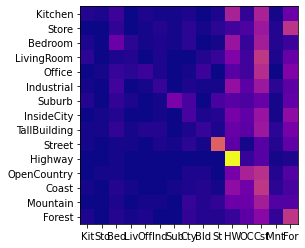

In [21]:
projSceneRecBoW('tiny_image', 'nearest_neighbor')

### Using very small images as well as the nearest neighbor classifier with 4 neighbours results in a very low accuracy of 20.200%. Looking at the confusion matrix, the highway images are quite accurately classified while everything else has very poor performances.

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
Loaded vocab from file.
Loaded vocab from file.
Using nearest_neighbor classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 54.600%
Wrote results page to results_webpage/index.html.


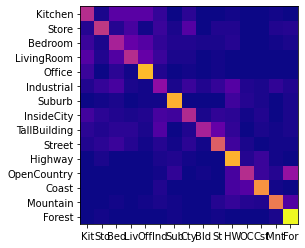

In [11]:
projSceneRecBoW('bag_of_words', 'nearest_neighbor')

### Using bag of words with the nearest neighbour classifier with 4 neighbours significantly improves the result as compared to using tiny images. However, 54.6% is still quite a low accuracy for image classification.

## BoW + Linear SVM

### Using the bag of word with linear SVM has a much better accuracy of 71.400%. Most classes are correctly classified except for kitchen, bedroom and living room.

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
Loaded vocab from file.
Loaded vocab from file.
Using support_vector_machine classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 71.400%
Wrote results page to results_webpage/index.html.


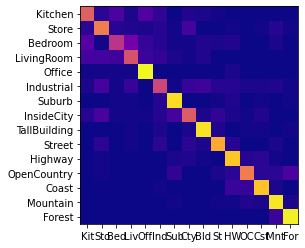

In [10]:
projSceneRecBoW('bag_of_words', 'support_vector_machine', 'linear')

## BoW + RBF SVM

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
Loaded vocab from file.
Loaded vocab from file.
Using support_vector_machine classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 69.800%
Wrote results page to results_webpage/index.html.


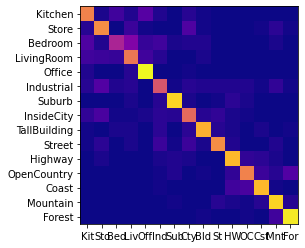

In [16]:
projSceneRecBoW('bag_of_words', 'support_vector_machine', 'rbf')

## BoW + chi-sqr SVM

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
Loaded vocab from file.
Loaded vocab from file.
Using support_vector_machine classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 90.000%
Wrote results page to results_webpage/index.html.


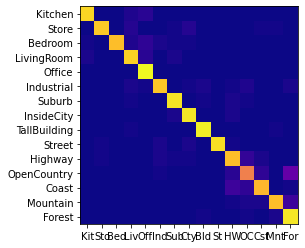

In [21]:
projSceneRecBoW('bag_of_words', 'support_vector_machine', 'chi_sqr')

### The rbf has slightly worse performance than the linear kernel while the chi-square performs extremly well with an accuracy of 90.000%. 

# 2. Results of BoW + Linear SVM with different vocabulary sizes

## vocabulary size of 10

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
No existing visual word vocabulary found. Computing one from training images.
(121104,)
(1261500, 144)
Loaded vocab from file.
Loaded vocab from file.
Using support_vector_machine classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 47.733%
Wrote results page to results_webpage/index.html.


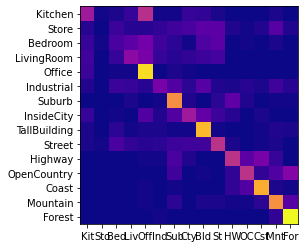

In [14]:
projSceneRecBoW('bag_of_words', 'support_vector_machine', 'linear', vocab_size = 10)

## vocabulary size of 20

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
No existing visual word vocabulary found. Computing one from training images.
(121104,)
(1261500, 144)
Loaded vocab from file.
Loaded vocab from file.
Using support_vector_machine classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 56.133%
Wrote results page to results_webpage/index.html.


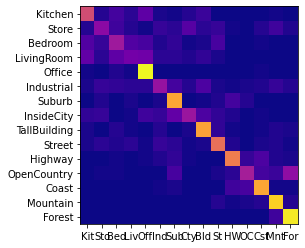

In [15]:
projSceneRecBoW('bag_of_words', 'support_vector_machine', 'linear', vocab_size = 20)

## vocabulary size of 50

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
No existing visual word vocabulary found. Computing one from training images.
(121104,)
(1261500, 144)
Loaded vocab from file.
Loaded vocab from file.
Using support_vector_machine classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 65.200%
Wrote results page to results_webpage/index.html.


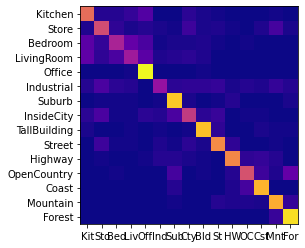

In [12]:
projSceneRecBoW('bag_of_words', 'support_vector_machine', 'linear', vocab_size = 50)

## vocabulary size of 100

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
No existing visual word vocabulary found. Computing one from training images.
(121104,)
(1261500, 144)
Loaded vocab from file.
Loaded vocab from file.
Using support_vector_machine classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 67.200%
Wrote results page to results_webpage/index.html.


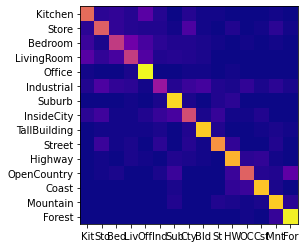

In [16]:
projSceneRecBoW('bag_of_words', 'support_vector_machine', 'linear', vocab_size = 100)

## vocabulary size of 400

Getting paths and labels for all train and test data.
Using bag_of_words representation for images.
No existing visual word vocabulary found. Computing one from training images.
(121104,)
(1261500, 144)
Loaded vocab from file.
Loaded vocab from file.
Using support_vector_machine classifier to predict test set categories.
Creating results_webpage/index.html, thumbnails, and confusion matrix.
Accuracy (mean of diagonal of confusion matrix) is 73.733%
Wrote results page to results_webpage/index.html.


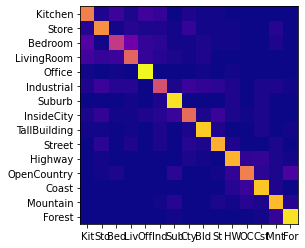

In [13]:
projSceneRecBoW('bag_of_words', 'support_vector_machine', 'linear', vocab_size = 400)

### As shown in the results using different vocabulary sizes, the classification accuracy increases as the vocabulary size increases. This is expected as more clusters in the kmeans will allow for more vocabularies to be built (more clusters to be identified). However, there should be a optimal number of clusters which in this case cannot be further explored due to the limited computational resources. Any number greater than 400 will take an extremely long time to run. Regardless, using a vocabulary size of 400 is able to achieve an accuracy of 73.733% using only a svm with linear kernel, and without spatial information or spatial pyramid implemented.